# Install Library

[RDKit ](https://github.com/rdkit/rdkit)

[DGL](https://github.com/dmlc/dgl/)

[DGL-LifeSci](https://github.com/awslabs/dgl-lifesci)





In [1]:
%%capture
!pip install rdkit-pypi
!pip install dgllife
!pip install --pre dgl-cu113 dglgo -f https://data.dgl.ai/wheels-test/repo.html

# Import Library

In [8]:
import os

import dgl 
import sys
import random
import torch
import cv2
import torchvision
import statistics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim


from rdkit.Chem import AllChem
from rdkit import Chem
from rdkit import DataStructs

from tensorflow.keras.utils import to_categorical
from dgllife.utils import smiles_to_bigraph, CanonicalAtomFeaturizer, AttentiveFPAtomFeaturizer
from tqdm.notebook import tqdm, trange
from sklearn.model_selection import train_test_split

from Utils.general import DATASET, get_dataset, separate_active_and_inactive_data, get_embedding_vector_class, count_lablel, data_generator
from Utils.gcn_pre_trained import get_muv_model
from model.heterogeneous_siamese_muv import siamese_model_attentiveFp_muv, siamese_model_Canonical_muv

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

ModuleNotFoundError: No module named 'gcn_pre_trained'

In [3]:
device = torch.device('cpu')

# Data

In [4]:
cache_path='./muv_dglgraph.bin'

df = get_dataset("muv")

ids = df['mol_id'].tolist()
load_full = False

df = df.drop(columns=['mol_id'])

In [5]:
df

,MUV-466,MUV-548,MUV-600,MUV-644,MUV-652,MUV-689,MUV-692,MUV-712,MUV-713,MUV-733,MUV-737,MUV-810,MUV-832,MUV-846,MUV-852,MUV-858,MUV-859,smiles
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,Cc1cccc(N2CCN(C(=O)C34CC5CC(CC(C5)C3)C4)CC2)c1C
1,0.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,0.0,0.0,Cn1ccnc1SCC(=O)Nc1ccc(Oc2ccccc2)cc1
2,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,COc1cc2c(cc1NC(=O)CN1C(=O)NC3(CCc4ccccc43)C1=O...
3,NaN,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,O=C1/C(=C/NC2CCS(=O)(=O)C2)c2ccccc2C(=O)N1c1cc...
4,0.0,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NC(=O)NC(Cc1ccccc1)C(=O)O
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93082,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,O=C(NCc1ccccc1Cl)C1CCCO1
93083,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COc1cc(NCCCCCN2C(=O)c3ccccc3C2=O)c2ncccc2c1
93084,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,CCN(CC)c1ccc(/C=C2/C(=O)ON=C2C)cc1
93085,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,Cc1cc(=O)oc2cc(OCC(=O)c3ccc4c(c3)NC(=O)CO4)ccc12


In [6]:
muv_tasks = df.columns.values[:17].tolist()

In [7]:
one = []
zero = []
nan = []
 
for task in muv_tasks:
    a = list(df[task].value_counts(dropna=False).to_dict().values())
    zero.append(a[0])
    nan.append(a[1])
    one.append(a[2])
    print(task ,"one:" ,a[2] ," zero:", a[0], " NAN:",a[1])


MUV-466 one: 27  zero: 78246  NAN: 14814
MUV-548 one: 29  zero: 78353  NAN: 14705
MUV-600 one: 30  zero: 78359  NAN: 14698
MUV-644 one: 30  zero: 78464  NAN: 14593
MUV-652 one: 29  zero: 78185  NAN: 14873
MUV-689 one: 29  zero: 78486  NAN: 14572
MUV-692 one: 30  zero: 78443  NAN: 14614
MUV-712 one: 28  zero: 78676  NAN: 14383
MUV-713 one: 29  zero: 78251  NAN: 14807
MUV-733 one: 28  zero: 78405  NAN: 14654
MUV-737 one: 29  zero: 78396  NAN: 14662
MUV-810 one: 29  zero: 78443  NAN: 14615
MUV-832 one: 30  zero: 78420  NAN: 14637
MUV-846 one: 30  zero: 78376  NAN: 14681
MUV-852 one: 29  zero: 78436  NAN: 14622
MUV-858 one: 29  zero: 78313  NAN: 14745
MUV-859 one: 24  zero: 78341  NAN: 14722


In [8]:
sum(one), sum(zero)

(489, 1332593)

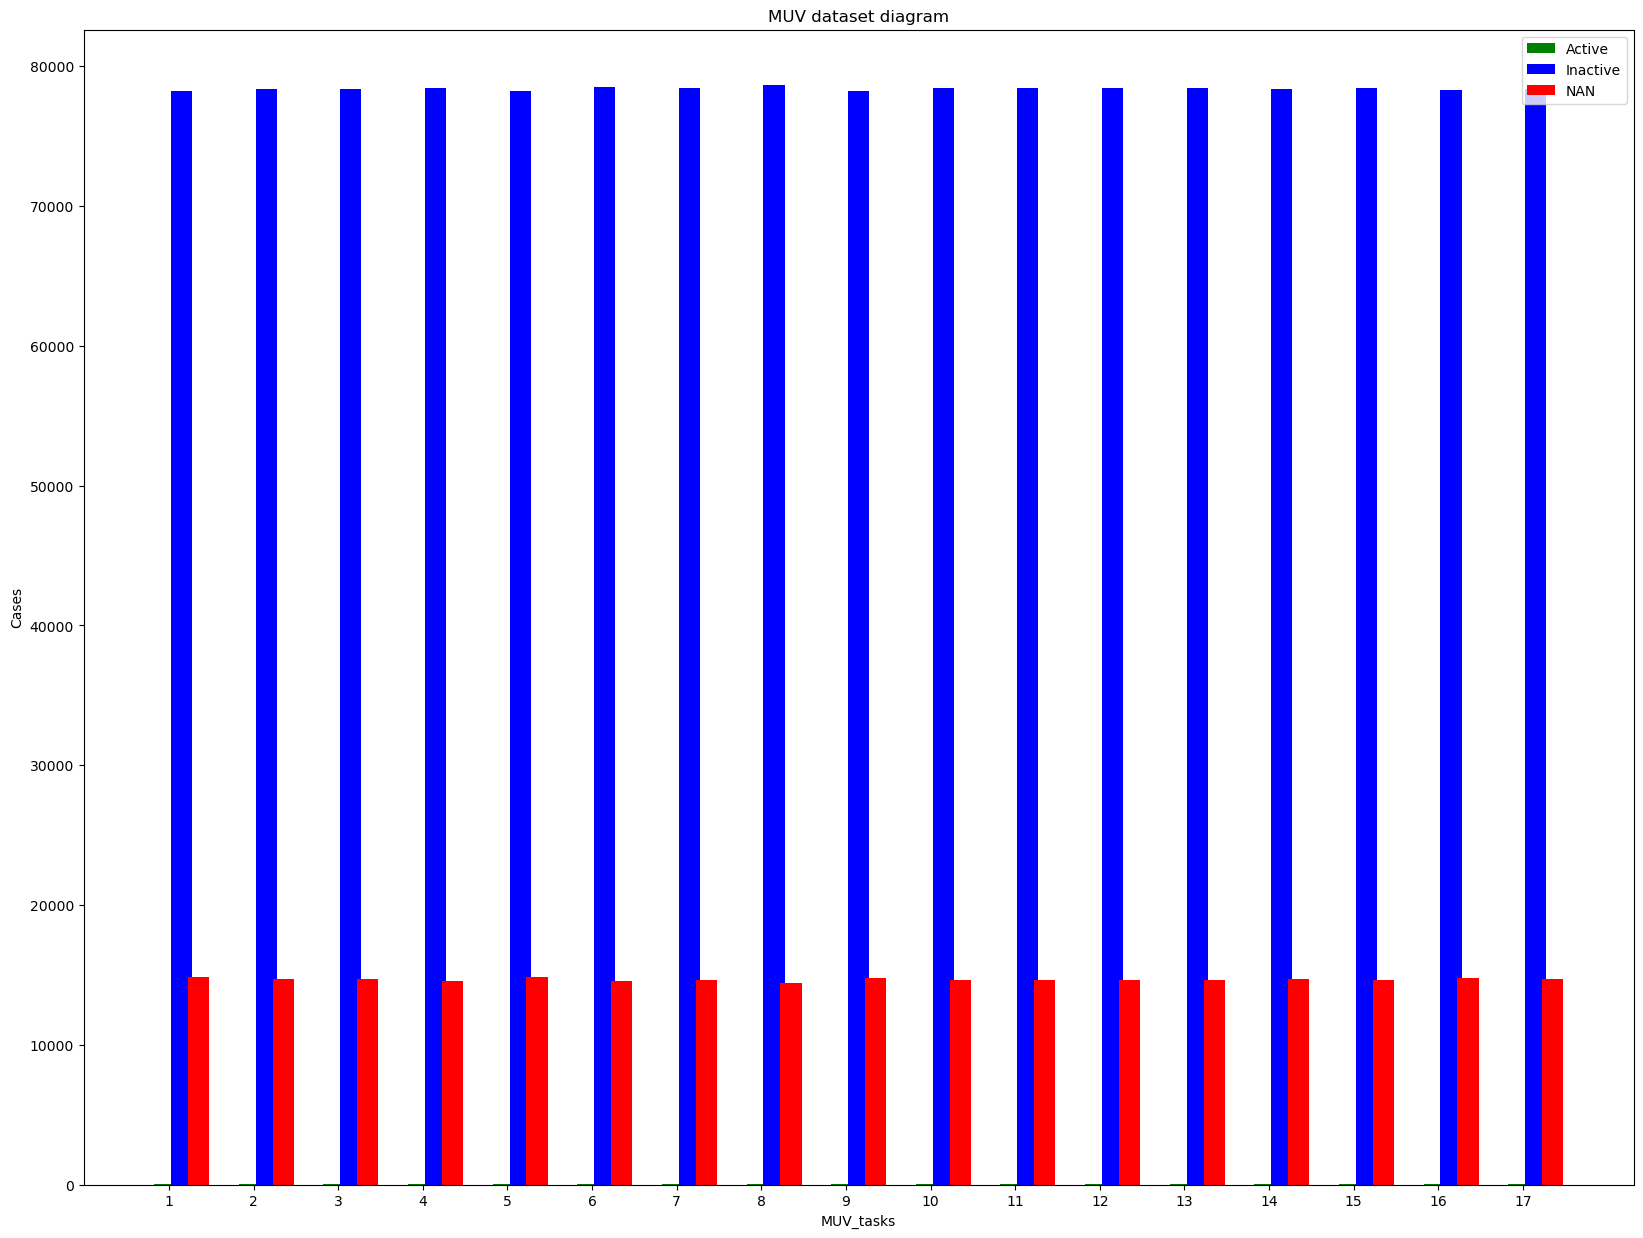

In [9]:
# Importing the matplotlib library
import numpy as np
import matplotlib.pyplot as plt
# Declaring the figure or the plot (y, x) or (width, height)
plt.figure(figsize=[20, 15])

X = np.arange(1,len(muv_tasks)+1)
plt.bar(X + 0.2, one, color = 'g', width = 0.25)
plt.bar(X + 0.4, zero, color = 'b', width = 0.25)
plt.bar(X + 0.6, nan, color = 'r', width = 0.25)

# Creating the legend of the bars in the plot
plt.legend(['Active' , 'Inactive' ,'NAN'])
# Overiding the x axis with the country names
plt.xticks([i + 0.25 for i in range(1,18)], X)
# Giving the tilte for the plot
plt.title("MUV dataset diagram")
# Namimg the x and y axis
plt.xlabel('MUV_tasks')
plt.ylabel('Cases')
# Saving the plot as a 'png'
plt.savefig('4BarPlot.png')
# Displaying the bar plot
plt.show()

# Required functions

In [10]:
from dgllife.model import MLPPredictor

def create_dataset_with_gcn(dataset, class_embed_vector, GCN, tasks, numberTask):

    created_data = []
    data = np.arange(len(tasks))
    onehot_encoded = to_categorical(data)

    for i, data in enumerate(dataset):
        smiles, g, label, mask = data
        g = g.to(device)
        g = dgl.add_self_loop(g)
        graph_feats = g.ndata.pop('h')
        embbed = GCN(g, graph_feats)
        embbed = embbed.to('cpu')
        embbed = embbed.detach().numpy()
        a = ( embbed, onehot_encoded[numberTask], class_embed_vector[numberTask], label, tasks[numberTask])
        created_data.append(a)
    print('Data created!!')
    return created_data 

# Calculation of embedded vectors for each class

In [13]:
df_positive, df_negative = separate_active_and_inactive_data(df, muv_tasks)

for i,d in enumerate(zip(df_positive,df_negative)):
    print(f'{muv_tasks[i]}=> positive: {len(d[0])} - negative: {len(d[1])}')

MUV-466=> positive: 27 - negative: 14814
MUV-548=> positive: 29 - negative: 14705
MUV-600=> positive: 30 - negative: 14698
MUV-644=> positive: 30 - negative: 14593
MUV-652=> positive: 29 - negative: 14873
MUV-689=> positive: 29 - negative: 14572
MUV-692=> positive: 30 - negative: 14614
MUV-712=> positive: 28 - negative: 14383
MUV-713=> positive: 29 - negative: 14807
MUV-733=> positive: 28 - negative: 14654
MUV-737=> positive: 29 - negative: 14662
MUV-810=> positive: 29 - negative: 14615
MUV-832=> positive: 30 - negative: 14637
MUV-846=> positive: 30 - negative: 14681
MUV-852=> positive: 29 - negative: 14622
MUV-858=> positive: 29 - negative: 14745
MUV-859=> positive: 24 - negative: 14722


In [14]:
dataset_positive = [DATASET(d,smiles_to_bigraph, AttentiveFPAtomFeaturizer(), cache_file_path = cache_path) for d in df_positive]
dataset_negative = [DATASET(d,smiles_to_bigraph, AttentiveFPAtomFeaturizer(), cache_file_path = cache_path) for d in df_negative]

Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing molecule 1000/14814
Processing molecule 2000/14814
Processing molecule 3000/14814
Processing molecule 4000/14814
Processing molecule 5000/14814
Processing molecule 6000/14814
Processing molecule 7000/14814
Processing molecule 8000/14814
Processing molecule 9000/14814
Processing molecule 10000/14814
Proce

Processing molecule 13000/14745
Processing molecule 14000/14745
Processing dgl graphs from scratch...
Processing molecule 1000/14722
Processing molecule 2000/14722
Processing molecule 3000/14722
Processing molecule 4000/14722
Processing molecule 5000/14722
Processing molecule 6000/14722
Processing molecule 7000/14722
Processing molecule 8000/14722
Processing molecule 9000/14722
Processing molecule 10000/14722
Processing molecule 11000/14722
Processing molecule 12000/14722
Processing molecule 13000/14722
Processing molecule 14000/14722


In [15]:
embed_class_muv = get_embedding_vector_class(dataset_positive, dataset_negative, radius=2, size = 512)

class vector created!!


# **Association-based strategy with BioAct-Het**

## Classification with BioAct-Het and AttentiveFp GCN

In [16]:
model_name = 'GCN_attentivefp_MUV'
gcn_model = get_muv_model(model_name)
gcn_model.eval()
gcn_model = gcn_model.to(device)

Pretrained model loaded


In [17]:
data_ds = []

for i, task in  enumerate(muv_tasks):
    a = df[['smiles' , task]]
    a = a.dropna()
    ds = DATASET(a, smiles_to_bigraph, AttentiveFPAtomFeaturizer(), cache_file_path = cache_path)
    data = create_dataset_with_gcn(ds, embed_class_muv, gcn_model, muv_tasks, i)
    for d in data:
        data_ds.append(d)

Processing dgl graphs from scratch...
Processing molecule 1000/14841
Processing molecule 2000/14841
Processing molecule 3000/14841
Processing molecule 4000/14841
Processing molecule 5000/14841
Processing molecule 6000/14841
Processing molecule 7000/14841
Processing molecule 8000/14841
Processing molecule 9000/14841
Processing molecule 10000/14841
Processing molecule 11000/14841
Processing molecule 12000/14841
Processing molecule 13000/14841
Processing molecule 14000/14841
Data created!!
Processing dgl graphs from scratch...
Processing molecule 1000/14734
Processing molecule 2000/14734
Processing molecule 3000/14734
Processing molecule 4000/14734
Processing molecule 5000/14734
Processing molecule 6000/14734
Processing molecule 7000/14734
Processing molecule 8000/14734
Processing molecule 9000/14734
Processing molecule 10000/14734
Processing molecule 11000/14734
Processing molecule 12000/14734
Processing molecule 13000/14734
Processing molecule 14000/14734
Data created!!
Processing dgl g

Processing molecule 11000/14746
Processing molecule 12000/14746
Processing molecule 13000/14746
Processing molecule 14000/14746
Data created!!


In [21]:
from sklearn.model_selection import KFold

Epoch_S = 15

def evaluate_model(df, k = 10 , shuffle = False):
    result =[]    

    kf = KFold(n_splits=10, shuffle= shuffle, random_state=None)
    
    for train_index, test_index in kf.split(df):

        train_ds = [df[index] for index in train_index] 
        
        valid_ds = [df[index] for index in test_index]
        
        label_pos , label_neg, _ , _ = count_lablel(train_ds)
        print(f'train positive label: {label_pos} - train negative label: {label_neg}')
        
        train_ds = up_and_down_Samplenig(train_ds, sacale_upsampling = 2 , scale_downsampling = 0.5)
        
        label_pos , label_neg , _ , _ = count_lablel(train_ds)
        print(f'up and down sampling => train positive label: {label_pos} - train negative label: {label_neg}')

        label_pos , label_neg, _ , _ = count_lablel(valid_ds)
        print(f'Test positive label: {label_pos} - Test negative label: {label_neg}')

        l_train = []
        r_train = []
        lbls_train = []
        l_valid = []
        r_valid = []
        lbls_valid = []

        for i , data in enumerate(train_ds):
            embbed_drug, onehot_task, embbed_task, lbl, task_name = data
            l_train.append(embbed_drug[0])
            r_train.append(embbed_task)
            lbls_train.append(lbl.tolist())
        
        for i , data in enumerate(valid_ds):
            embbed_drug, onehot_task, embbed_task, lbl, task_name = data
            l_valid.append(embbed_drug[0])
            r_valid.append(embbed_task)
            lbls_valid.append(lbl.tolist())

        l_train = np.array(l_train).reshape(-1,128,1)
        r_train = np.array(r_train).reshape(-1,512,1)
        lbls_train = np.array(lbls_train)

        l_valid = np.array(l_valid).reshape(-1,128,1)
        r_valid = np.array(r_valid).reshape(-1,512,1)
        lbls_valid = np.array(lbls_valid)

        # create neural network model
        siamese_net = siamese_model_attentiveFp_muv()
        history = History()
        P = siamese_net.fit([l_train, r_train], lbls_train, epochs = Epoch_S, batch_size = 128, callbacks=[history])

        for j in range(100):
            C=1
            Before = int(P.history['accuracy'][-1]*100)
            for i in range(2,Epoch_S+1):
                if  int(P.history['accuracy'][-i]*100) == Before:
                    C=C+1
                else:
                    C=1
                Before=int(P.history['accuracy'][-i]*100)
                print(Before)
            if C==Epoch_S:
                break
            P = siamese_net.fit([l_train, r_train], lbls_train, epochs = Epoch_S, batch_size = 128, callbacks=[history])
        print(j+1)
        
        score  = siamese_net.evaluate([l_valid,r_valid], lbls_valid, verbose=1)
        a = (score[1],score[4])
        result.append(a)
    
    return result

scores = evaluate_model(data_ds, 10, True)

train positive label: 443 - train negative label: 224454
up and down sampling => train positive label: 74867 - train negative label: 224454
Test positive label: 46 - Test negative label: 24943
Epoch 1/15
2339/2339 [==============================] - 9s 4ms/step - loss: 0.5575 - accuracy: 0.7496 - mae: 0.3706 - mse: 0.1856 - auc_17: 0.5725
Epoch 2/15
2339/2339 [==============================] - 9s 4ms/step - loss: 0.5248 - accuracy: 0.7528 - mae: 0.3491 - mse: 0.1743 - auc_17: 0.6708
Epoch 3/15
2339/2339 [==============================] - 9s 4ms/step - loss: 0.5187 - accuracy: 0.7589 - mae: 0.3440 - mse: 0.1719 - auc_17: 0.6818
Epoch 4/15
2339/2339 [==============================] - 9s 4ms/step - loss: 0.5169 - accuracy: 0.7609 - mae: 0.3421 - mse: 0.1709 - auc_17: 0.6864
Epoch 5/15
2339/2339 [==============================] - 9s 4ms/step - loss: 0.5161 - accuracy: 0.7617 - mae: 0.3411 - mse: 0.1704 - auc_17: 0.6894
Epoch 6/15
2339/2339 [==============================] - 9s 4ms/step - lo

2341/2341 [==============================] - 10s 4ms/step - loss: 0.4790 - accuracy: 0.7745 - mae: 0.3144 - mse: 0.1571 - auc_19: 0.7553
Epoch 15/15
2341/2341 [==============================] - 10s 4ms/step - loss: 0.4782 - accuracy: 0.7748 - mae: 0.3139 - mse: 0.1569 - auc_19: 0.7566
77
77
77
77
77
77
77
77
77
76
76
76
76
76
Epoch 1/15
2341/2341 [==============================] - 10s 4ms/step - loss: 0.4767 - accuracy: 0.7762 - mae: 0.3129 - mse: 0.1564 - auc_19: 0.7582
Epoch 2/15
2341/2341 [==============================] - 10s 4ms/step - loss: 0.4747 - accuracy: 0.7765 - mae: 0.3112 - mse: 0.1557 - auc_19: 0.7615
Epoch 3/15
2341/2341 [==============================] - 10s 4ms/step - loss: 0.4733 - accuracy: 0.7760 - mae: 0.3106 - mse: 0.1553 - auc_19: 0.7639
Epoch 4/15
2341/2341 [==============================] - 10s 4ms/step - loss: 0.4719 - accuracy: 0.7768 - mae: 0.3098 - mse: 0.1548 - auc_19: 0.7657
Epoch 5/15
2341/2341 [==============================] - 10s 4ms/step - loss: 0.4

2340/2340 [==============================] - 9s 4ms/step - loss: 0.4833 - accuracy: 0.7757 - mae: 0.3168 - mse: 0.1583 - auc_20: 0.7477
Epoch 7/15
2340/2340 [==============================] - 9s 4ms/step - loss: 0.4856 - accuracy: 0.7750 - mae: 0.3183 - mse: 0.1591 - auc_20: 0.7434
Epoch 8/15
2340/2340 [==============================] - 9s 4ms/step - loss: 0.4834 - accuracy: 0.7763 - mae: 0.3165 - mse: 0.1583 - auc_20: 0.7464
Epoch 9/15
2340/2340 [==============================] - 9s 4ms/step - loss: 0.4813 - accuracy: 0.7765 - mae: 0.3154 - mse: 0.1576 - auc_20: 0.7501
Epoch 10/15
2340/2340 [==============================] - 9s 4ms/step - loss: 0.4792 - accuracy: 0.7770 - mae: 0.3143 - mse: 0.1570 - auc_20: 0.7531
Epoch 11/15
2340/2340 [==============================] - 9s 4ms/step - loss: 0.4785 - accuracy: 0.7769 - mae: 0.3135 - mse: 0.1568 - auc_20: 0.7547
Epoch 12/15
2340/2340 [==============================] - 9s 4ms/step - loss: 0.4767 - accuracy: 0.7771 - mae: 0.3123 - mse: 0.1

2342/2342 [==============================] - 8s 4ms/step - loss: 0.4679 - accuracy: 0.7734 - mae: 0.3089 - mse: 0.1543 - auc_22: 0.7702
Epoch 6/15
2342/2342 [==============================] - 8s 4ms/step - loss: 0.4673 - accuracy: 0.7746 - mae: 0.3080 - mse: 0.1540 - auc_22: 0.7717
Epoch 7/15
2342/2342 [==============================] - 8s 4ms/step - loss: 0.4662 - accuracy: 0.7748 - mae: 0.3073 - mse: 0.1536 - auc_22: 0.7732
Epoch 8/15
2342/2342 [==============================] - 8s 4ms/step - loss: 0.4640 - accuracy: 0.7765 - mae: 0.3056 - mse: 0.1527 - auc_22: 0.7763
Epoch 9/15
2342/2342 [==============================] - 8s 4ms/step - loss: 0.4639 - accuracy: 0.7768 - mae: 0.3055 - mse: 0.1527 - auc_22: 0.7765
Epoch 10/15
2342/2342 [==============================] - 8s 4ms/step - loss: 0.4615 - accuracy: 0.7778 - mae: 0.3036 - mse: 0.1517 - auc_22: 0.7800
Epoch 11/15
2342/2342 [==============================] - 8s 4ms/step - loss: 0.4628 - accuracy: 0.7769 - mae: 0.3045 - mse: 0.15

2341/2341 [==============================] - 11s 5ms/step - loss: 0.4942 - accuracy: 0.7671 - mae: 0.3248 - mse: 0.1624 - auc_25: 0.7349
Epoch 2/15
2341/2341 [==============================] - 11s 5ms/step - loss: 0.4991 - accuracy: 0.7661 - mae: 0.3279 - mse: 0.1639 - auc_25: 0.7262
Epoch 3/15
2341/2341 [==============================] - 11s 5ms/step - loss: 0.4977 - accuracy: 0.7669 - mae: 0.3270 - mse: 0.1634 - auc_25: 0.7282
Epoch 4/15
2341/2341 [==============================] - 11s 5ms/step - loss: 0.4974 - accuracy: 0.7663 - mae: 0.3270 - mse: 0.1635 - auc_25: 0.7291
Epoch 5/15
2341/2341 [==============================] - 11s 5ms/step - loss: 0.4941 - accuracy: 0.7682 - mae: 0.3248 - mse: 0.1623 - auc_25: 0.7338
Epoch 6/15
2341/2341 [==============================] - 11s 5ms/step - loss: 0.4937 - accuracy: 0.7672 - mae: 0.3242 - mse: 0.1622 - auc_25: 0.7350
Epoch 7/15
2341/2341 [==============================] - 11s 5ms/step - loss: 0.4913 - accuracy: 0.7688 - mae: 0.3230 - mse:

#### Dropout = 0.2 and downsampling = 0.5 

In [58]:
scores

[(0.8442114591598511, 0.7468533515930176),
 (0.847372829914093, 0.712647557258606),
 (0.9030373096466064, 0.63388991355896),
 (0.8979150652885437, 0.6568703651428223),
 (0.8518548011779785, 0.7641416788101196),
 (0.8734242916107178, 0.7440401911735535),
 (0.9291660189628601, 0.7043888568878174),
 (0.8433648347854614, 0.6350152492523193),
 (0.8867856860160828, 0.6838277578353882),
 (0.8933087587356567, 0.6661195755004883)]

In [59]:
acc = []
auc = []
for i in scores:
    acc.append(i[0])
    auc.append(i[1])

print(f'accuracy= {np.mean(acc)} AUC= {np.mean(auc)} STD_AUC= {np.std(auc)}')

accuracy= 0.8770441055297852 AUC= 0.6947794497013092 STD_AUC= 0.0447423318711194


#### Dropout = 0.2 and downsampling = 0.4    

In [22]:
scores

[(0.9799911975860596, 0.6839089393615723),
 (0.9724278450012207, 0.6760334372520447),
 (0.9283685088157654, 0.6512341499328613),
 (0.9422145485877991, 0.6853597164154053),
 (0.9685461521148682, 0.6880980134010315),
 (0.9613829851150513, 0.5966234803199768),
 (0.9635825157165527, 0.737411618232727),
 (0.9463342428207397, 0.6501477956771851),
 (0.9705058336257935, 0.7068324089050293),
 (0.9661437273025513, 0.7074846029281616)]

In [23]:
acc = []
auc = []
for i in scores:
    acc.append(i[0])
    auc.append(i[1])

print(f'accuracy= {np.mean(acc)} AUC= {np.mean(auc)} STD_AUC= {np.std(auc)}')

accuracy= 0.9599497556686402 AUC= 0.6783134162425994 STD_AUC= 0.03679486363772909


#### Dropout = 0.3 and downsampling = 0.5 

In [50]:
scores

[(0.8336067795753479, 0.7119942903518677),
 (0.8947536945343018, 0.7315952181816101),
 (0.9348112940788269, 0.6853195428848267),
 (0.9263275861740112, 0.694881796836853),
 (0.9514986872673035, 0.6474282741546631),
 (0.910320520401001, 0.6676397919654846),
 (0.8270769715309143, 0.6636998653411865),
 (0.8757003545761108, 0.6882363557815552),
 (0.9979190230369568, 0.5),
 (0.7480790615081787, 0.7459204196929932)]

In [51]:
acc = []
auc = []
for i in scores:
    acc.append(i[0])
    auc.append(i[1])
print(f'accuracy= {np.mean(acc)} AUC= {np.mean(auc)}')

accuracy= 0.8900093972682953 AUC= 0.673671555519104


## Classification with BioAct-Het and Canonical GCN 

In [24]:
model_GCN = 'GCN_canonical_MUV'
gcn_model = get_muv_model(model_GCN)
gcn_model.eval()
gcn_model = gcn_model.to(device)

Pretrained model loaded


In [25]:
data_ds = []
for i, task in  enumerate(muv_tasks):
    a = df[['smiles' , task]]
    a = a.dropna()
    ds = DATASET(a, smiles_to_bigraph, CanonicalAtomFeaturizer(), cache_file_path = cache_path)
    data = create_dataset_with_gcn(ds, embed_class_muv, gcn_model, muv_tasks, i)
    for d in data:
        data_ds.append(d)

Processing dgl graphs from scratch...
Processing molecule 1000/14841
Processing molecule 2000/14841
Processing molecule 3000/14841
Processing molecule 4000/14841
Processing molecule 5000/14841
Processing molecule 6000/14841
Processing molecule 7000/14841
Processing molecule 8000/14841
Processing molecule 9000/14841
Processing molecule 10000/14841
Processing molecule 11000/14841
Processing molecule 12000/14841
Processing molecule 13000/14841
Processing molecule 14000/14841
Data created!!
Processing dgl graphs from scratch...
Processing molecule 1000/14734
Processing molecule 2000/14734
Processing molecule 3000/14734
Processing molecule 4000/14734
Processing molecule 5000/14734
Processing molecule 6000/14734
Processing molecule 7000/14734
Processing molecule 8000/14734
Processing molecule 9000/14734
Processing molecule 10000/14734
Processing molecule 11000/14734
Processing molecule 12000/14734
Processing molecule 13000/14734
Processing molecule 14000/14734
Data created!!
Processing dgl g

Processing molecule 11000/14746
Processing molecule 12000/14746
Processing molecule 13000/14746
Processing molecule 14000/14746
Data created!!


In [27]:
from sklearn.model_selection import KFold

Epoch_S = 15

def evaluate_model(df, k = 10 , shuffle = False):
    result =[]    

    kf = KFold(n_splits=10, shuffle= shuffle, random_state=None)
    
    for train_index, test_index in kf.split(df):

        train_ds = [df[index] for index in train_index] 
        
        valid_ds = [df[index] for index in test_index]
        
        label_pos , label_neg, _ , _ = count_lablel(train_ds)
        print(f'train positive label: {label_pos} - train negative label: {label_neg}')
        
        train_ds = up_and_down_Samplenig(train_ds, sacale_upsampling = 2 , scale_downsampling = 0.5)
        
        label_pos , label_neg , _ , _ = count_lablel(train_ds)
        print(f'up and down sampling => train positive label: {label_pos} - train negative label: {label_neg}')

        label_pos , label_neg, _ , _ = count_lablel(valid_ds)
        print(f'Test positive label: {label_pos} - Test negative label: {label_neg}')

        l_train = []
        r_train = []
        lbls_train = []
        l_valid = []
        r_valid = []
        lbls_valid = []

        for i , data in enumerate(train_ds):
            embbed_drug, onehot_task, embbed_task, lbl, task_name = data
            l_train.append(embbed_drug[0])
            r_train.append(embbed_task)
            lbls_train.append(lbl.tolist())
        
        for i , data in enumerate(valid_ds):
            embbed_drug, onehot_task, embbed_task, lbl, task_name = data
            l_valid.append(embbed_drug[0])
            r_valid.append(embbed_task)
            lbls_valid.append(lbl.tolist())

        l_train = np.array(l_train).reshape(-1,128,1)
        r_train = np.array(r_train).reshape(-1,512,1)
        lbls_train = np.array(lbls_train)

        l_valid = np.array(l_valid).reshape(-1,128,1)
        r_valid = np.array(r_valid).reshape(-1,512,1)
        lbls_valid = np.array(lbls_valid)

        # create neural network model
        siamese_net = siamese_model_Canonical_muv()
        history = History()
        P = siamese_net.fit([l_train, r_train], lbls_train, epochs = Epoch_S, batch_size = 128, callbacks=[history])

        for j in range(100):
            C=1
            Before = int(P.history['accuracy'][-1]*100)
            for i in range(2,Epoch_S+1):
                if  int(P.history['accuracy'][-i]*100) == Before:
                    C=C+1
                else:
                    C=1
                Before=int(P.history['accuracy'][-i]*100)
                print(Before)
            if C==Epoch_S:
                break
            P = siamese_net.fit([l_train, r_train], lbls_train, epochs = Epoch_S, batch_size = 128, callbacks=[history])
        print(j+1)
        
        score  = siamese_net.evaluate([l_valid,r_valid], lbls_valid, verbose=1)
        a = (score[1],score[4])
        result.append(a)
    
    return result

scores = evaluate_model(data_ds, 10, True)

train positive label: 441 - train negative label: 224456
up and down sampling => train positive label: 112455 - train negative label: 224456
Test positive label: 48 - Test negative label: 24941
Epoch 1/15
2633/2633 [==============================] - 11s 4ms/step - loss: 0.6093 - accuracy: 0.6719 - mae: 0.4209 - mse: 0.2108 - auc_27: 0.6369
Epoch 2/15
2633/2633 [==============================] - 11s 4ms/step - loss: 0.5791 - accuracy: 0.6914 - mae: 0.3982 - mse: 0.1988 - auc_27: 0.6963
Epoch 3/15
2633/2633 [==============================] - 11s 4ms/step - loss: 0.5672 - accuracy: 0.6982 - mae: 0.3896 - mse: 0.1944 - auc_27: 0.7150
Epoch 4/15
2633/2633 [==============================] - 11s 4ms/step - loss: 0.5565 - accuracy: 0.7025 - mae: 0.3814 - mse: 0.1904 - auc_27: 0.7301
Epoch 5/15
2633/2633 [==============================] - 11s 4ms/step - loss: 0.5498 - accuracy: 0.7058 - mae: 0.3763 - mse: 0.1879 - auc_27: 0.7396
Epoch 6/15
2633/2633 [==============================] - 11s 4ms/st

2633/2633 [==============================] - 11s 4ms/step - loss: 0.4391 - accuracy: 0.7699 - mae: 0.2950 - mse: 0.1475 - auc_27: 0.8505
Epoch 10/15
2633/2633 [==============================] - 11s 4ms/step - loss: 0.4392 - accuracy: 0.7703 - mae: 0.2951 - mse: 0.1475 - auc_27: 0.8504
Epoch 11/15
2633/2633 [==============================] - 11s 4ms/step - loss: 0.4389 - accuracy: 0.7699 - mae: 0.2950 - mse: 0.1474 - auc_27: 0.8505
Epoch 12/15
2633/2633 [==============================] - 11s 4ms/step - loss: 0.4387 - accuracy: 0.7698 - mae: 0.2948 - mse: 0.1473 - auc_27: 0.8509
Epoch 13/15
2633/2633 [==============================] - 11s 4ms/step - loss: 0.4372 - accuracy: 0.7712 - mae: 0.2935 - mse: 0.1468 - auc_27: 0.8520
Epoch 14/15
2633/2633 [==============================] - 11s 4ms/step - loss: 0.4364 - accuracy: 0.7708 - mae: 0.2934 - mse: 0.1466 - auc_27: 0.8523
Epoch 15/15
2633/2633 [==============================] - 11s 4ms/step - loss: 0.4322 - accuracy: 0.7738 - mae: 0.2902 

2632/2632 [==============================] - 9s 4ms/step - loss: 0.4374 - accuracy: 0.7765 - mae: 0.2938 - mse: 0.1468 - auc_28: 0.8524
Epoch 11/15
2632/2632 [==============================] - 9s 4ms/step - loss: 0.4411 - accuracy: 0.7723 - mae: 0.2966 - mse: 0.1483 - auc_28: 0.8491
Epoch 12/15
2632/2632 [==============================] - 9s 4ms/step - loss: 0.4437 - accuracy: 0.7708 - mae: 0.2988 - mse: 0.1493 - auc_28: 0.8468
Epoch 13/15
2632/2632 [==============================] - 9s 4ms/step - loss: 0.4428 - accuracy: 0.7712 - mae: 0.2980 - mse: 0.1489 - auc_28: 0.8476
Epoch 14/15
2632/2632 [==============================] - 9s 4ms/step - loss: 0.4405 - accuracy: 0.7721 - mae: 0.2965 - mse: 0.1481 - auc_28: 0.8493
Epoch 15/15
2632/2632 [==============================] - 9s 4ms/step - loss: 0.4382 - accuracy: 0.7746 - mae: 0.2946 - mse: 0.1472 - auc_28: 0.8513
77
77
77
77
77
77
77
77
76
76
76
76
76
76
Epoch 1/15
2632/2632 [==============================] - 9s 4ms/step - loss: 0.4369

2632/2632 [==============================] - 9s 3ms/step - loss: 0.4458 - accuracy: 0.7659 - mae: 0.3004 - mse: 0.1501 - auc_29: 0.8448
Epoch 12/15
2632/2632 [==============================] - 9s 3ms/step - loss: 0.4450 - accuracy: 0.7664 - mae: 0.2997 - mse: 0.1497 - auc_29: 0.8455
Epoch 13/15
2632/2632 [==============================] - 9s 3ms/step - loss: 0.4444 - accuracy: 0.7671 - mae: 0.2993 - mse: 0.1497 - auc_29: 0.8456
Epoch 14/15
2632/2632 [==============================] - 9s 3ms/step - loss: 0.4408 - accuracy: 0.7694 - mae: 0.2968 - mse: 0.1482 - auc_29: 0.8488
Epoch 15/15
2632/2632 [==============================] - 9s 3ms/step - loss: 0.4408 - accuracy: 0.7690 - mae: 0.2968 - mse: 0.1483 - auc_29: 0.8487
76
76
76
76
76
76
76
76
76
76
75
75
75
75
Epoch 1/15
2632/2632 [==============================] - 9s 4ms/step - loss: 0.4393 - accuracy: 0.7714 - mae: 0.2955 - mse: 0.1477 - auc_29: 0.8500
Epoch 2/15
2632/2632 [==============================] - 9s 4ms/step - loss: 0.4392 

2634/2634 [==============================] - 9s 3ms/step - loss: 0.4260 - accuracy: 0.7837 - mae: 0.2845 - mse: 0.1421 - auc_30: 0.8612
Epoch 13/15
2634/2634 [==============================] - 9s 3ms/step - loss: 0.4289 - accuracy: 0.7813 - mae: 0.2863 - mse: 0.1431 - auc_30: 0.8590
Epoch 14/15
2634/2634 [==============================] - 9s 3ms/step - loss: 0.4299 - accuracy: 0.7791 - mae: 0.2872 - mse: 0.1437 - auc_30: 0.8578
Epoch 15/15
2634/2634 [==============================] - 9s 3ms/step - loss: 0.4314 - accuracy: 0.7789 - mae: 0.2886 - mse: 0.1442 - auc_30: 0.8568
77
78
78
78
78
78
78
77
77
78
77
77
77
77
Epoch 1/15
2634/2634 [==============================] - 9s 3ms/step - loss: 0.4279 - accuracy: 0.7808 - mae: 0.2857 - mse: 0.1428 - auc_30: 0.8596
Epoch 2/15
2634/2634 [==============================] - 9s 3ms/step - loss: 0.4305 - accuracy: 0.7796 - mae: 0.2879 - mse: 0.1438 - auc_30: 0.8575
Epoch 3/15
2634/2634 [==============================] - 9s 3ms/step - loss: 0.4265 -

2634/2634 [==============================] - 9s 3ms/step - loss: 0.4344 - accuracy: 0.7735 - mae: 0.2918 - mse: 0.1459 - auc_31: 0.8535
Epoch 14/15
2634/2634 [==============================] - 9s 3ms/step - loss: 0.4336 - accuracy: 0.7746 - mae: 0.2911 - mse: 0.1455 - auc_31: 0.8545
Epoch 15/15
2634/2634 [==============================] - 9s 3ms/step - loss: 0.4336 - accuracy: 0.7726 - mae: 0.2915 - mse: 0.1458 - auc_31: 0.8538
77
77
77
77
77
77
77
77
76
76
76
76
76
76
Epoch 1/15
2634/2634 [==============================] - 9s 3ms/step - loss: 0.4300 - accuracy: 0.7754 - mae: 0.2890 - mse: 0.1444 - auc_31: 0.8566
Epoch 2/15
2634/2634 [==============================] - 9s 3ms/step - loss: 0.4308 - accuracy: 0.7754 - mae: 0.2891 - mse: 0.1446 - auc_31: 0.8563
Epoch 3/15
2634/2634 [==============================] - 9s 3ms/step - loss: 0.4288 - accuracy: 0.7762 - mae: 0.2880 - mse: 0.1439 - auc_31: 0.8577
Epoch 4/15
2634/2634 [==============================] - 9s 3ms/step - loss: 0.4283 - 

2632/2632 [==============================] - 9s 4ms/step - loss: 0.4114 - accuracy: 0.7949 - mae: 0.2734 - mse: 0.1366 - auc_32: 0.8723
Epoch 13/15
2632/2632 [==============================] - 9s 4ms/step - loss: 0.4106 - accuracy: 0.7957 - mae: 0.2727 - mse: 0.1364 - auc_32: 0.8728
Epoch 14/15
2632/2632 [==============================] - 9s 4ms/step - loss: 0.4110 - accuracy: 0.7952 - mae: 0.2731 - mse: 0.1365 - auc_32: 0.8725
Epoch 15/15
2632/2632 [==============================] - 9s 4ms/step - loss: 0.4124 - accuracy: 0.7944 - mae: 0.2739 - mse: 0.1369 - auc_32: 0.8718
79
79
79
79
79
79
79
79
79
79
78
78
79
78
Epoch 1/15
2632/2632 [==============================] - 9s 4ms/step - loss: 0.4098 - accuracy: 0.7955 - mae: 0.2723 - mse: 0.1361 - auc_32: 0.8733
Epoch 2/15
2632/2632 [==============================] - 9s 4ms/step - loss: 0.4098 - accuracy: 0.7967 - mae: 0.2718 - mse: 0.1359 - auc_32: 0.8737
Epoch 3/15
2632/2632 [==============================] - 9s 4ms/step - loss: 0.4101 -

2632/2632 [==============================] - 9s 4ms/step - loss: 0.4282 - accuracy: 0.7822 - mae: 0.2869 - mse: 0.1433 - auc_33: 0.8596
Epoch 14/15
2632/2632 [==============================] - 9s 4ms/step - loss: 0.4255 - accuracy: 0.7843 - mae: 0.2850 - mse: 0.1423 - auc_33: 0.8616
Epoch 15/15
2632/2632 [==============================] - 9s 4ms/step - loss: 0.4258 - accuracy: 0.7838 - mae: 0.2852 - mse: 0.1425 - auc_33: 0.8612
78
78
78
78
78
78
77
78
77
77
77
77
77
77
Epoch 1/15
2632/2632 [==============================] - 9s 3ms/step - loss: 0.4246 - accuracy: 0.7845 - mae: 0.2843 - mse: 0.1420 - auc_33: 0.8622
Epoch 2/15
2632/2632 [==============================] - 9s 3ms/step - loss: 0.4236 - accuracy: 0.7865 - mae: 0.2831 - mse: 0.1413 - auc_33: 0.8635
Epoch 3/15
2632/2632 [==============================] - 9s 3ms/step - loss: 0.4247 - accuracy: 0.7856 - mae: 0.2840 - mse: 0.1418 - auc_33: 0.8627
Epoch 4/15
2632/2632 [==============================] - 9s 3ms/step - loss: 0.4232 - 

2634/2634 [==============================] - 10s 4ms/step - loss: 0.4370 - accuracy: 0.7696 - mae: 0.2937 - mse: 0.1468 - auc_34: 0.8515
Epoch 15/15
2634/2634 [==============================] - 10s 4ms/step - loss: 0.4390 - accuracy: 0.7686 - mae: 0.2948 - mse: 0.1475 - auc_34: 0.8500
76
76
76
76
76
76
76
76
76
76
76
76
76
76
5
781/781 [==============================] - 1s 663us/step - loss: 0.3021 - accuracy: 0.8927 - mae: 0.2244 - mse: 0.0936 - auc_34: 0.7094
train positive label: 440 - train negative label: 224458
up and down sampling => train positive label: 112640 - train negative label: 224458
Test positive label: 49 - Test negative label: 24939
Epoch 1/15
2634/2634 [==============================] - 10s 4ms/step - loss: 0.6093 - accuracy: 0.6740 - mae: 0.4201 - mse: 0.2105 - auc_35: 0.6398
Epoch 2/15
2634/2634 [==============================] - 10s 4ms/step - loss: 0.5802 - accuracy: 0.6951 - mae: 0.3976 - mse: 0.1986 - auc_35: 0.6973
Epoch 3/15
2634/2634 [======================

2634/2634 [==============================] - 10s 4ms/step - loss: 0.4734 - accuracy: 0.7493 - mae: 0.3212 - mse: 0.1606 - auc_36: 0.8201
Epoch 13/15
2634/2634 [==============================] - 10s 4ms/step - loss: 0.4721 - accuracy: 0.7505 - mae: 0.3202 - mse: 0.1600 - auc_36: 0.8214
Epoch 14/15
2634/2634 [==============================] - 10s 4ms/step - loss: 0.4703 - accuracy: 0.7516 - mae: 0.3189 - mse: 0.1594 - auc_36: 0.8230
Epoch 15/15
2634/2634 [==============================] - 10s 4ms/step - loss: 0.4676 - accuracy: 0.7531 - mae: 0.3171 - mse: 0.1584 - auc_36: 0.8253
75
75
74
74
74
74
74
74
74
74
73
73
73
73
Epoch 1/15
2634/2634 [==============================] - 10s 4ms/step - loss: 0.4679 - accuracy: 0.7519 - mae: 0.3171 - mse: 0.1586 - auc_36: 0.8250
Epoch 2/15
2634/2634 [==============================] - 10s 4ms/step - loss: 0.4642 - accuracy: 0.7552 - mae: 0.3146 - mse: 0.1572 - auc_36: 0.8285
Epoch 3/15
2634/2634 [==============================] - 10s 4ms/step - loss: 0

2634/2634 [==============================] - 10s 4ms/step - loss: 0.3959 - accuracy: 0.8015 - mae: 0.2626 - mse: 0.1311 - auc_36: 0.8829
80
80
80
80
79
79
79
79
79
79
79
80
80
79
Epoch 1/15
2634/2634 [==============================] - 10s 4ms/step - loss: 0.3939 - accuracy: 0.8017 - mae: 0.2610 - mse: 0.1305 - auc_36: 0.8840
Epoch 2/15
2634/2634 [==============================] - 10s 4ms/step - loss: 0.3910 - accuracy: 0.8026 - mae: 0.2591 - mse: 0.1296 - auc_36: 0.8857
Epoch 3/15
2634/2634 [==============================] - 10s 4ms/step - loss: 0.3913 - accuracy: 0.8031 - mae: 0.2593 - mse: 0.1295 - auc_36: 0.8858
Epoch 4/15
2634/2634 [==============================] - 10s 4ms/step - loss: 0.3921 - accuracy: 0.8030 - mae: 0.2598 - mse: 0.1299 - auc_36: 0.8851
Epoch 5/15
2634/2634 [==============================] - 10s 4ms/step - loss: 0.3920 - accuracy: 0.8027 - mae: 0.2596 - mse: 0.1297 - auc_36: 0.8855
Epoch 6/15
2634/2634 [==============================] - 10s 4ms/step - loss: 0.39

#### Dropout = 0.2 and downsampling = 0.5 

In [28]:
scores

[(0.8201208710670471, 0.7097600698471069),
 (0.8498939275741577, 0.639973521232605),
 (0.8861899375915527, 0.6834255456924438),
 (0.8530153036117554, 0.6460467576980591),
 (0.865900993347168, 0.7278987169265747),
 (0.9073192477226257, 0.7258636355400085),
 (0.8746198415756226, 0.6931874752044678),
 (0.8926684856414795, 0.709435224533081),
 (0.8656154870986938, 0.6582207679748535),
 (0.8484072089195251, 0.6405272483825684)]

In [29]:
acc = []
auc = []
for i in scores:
    acc.append(i[0])
    auc.append(i[1])

print(f'accuracy= {np.mean(acc)} AUC= {np.mean(auc)} STD_AUC= {np.std(auc)}')

accuracy= 0.8663751304149627 AUC= 0.6834338963031769 STD_AUC= 0.03317371928095168
